# <span style="font-size: 1em">Data Mining</span><span style="font-size: 0.8em"> Assignment 1</span>
<h3>Data Mining 2022-2023</h3>
<h5>M.Sc. In Business Analytics (Part Time) 2022-2024 at Athens University of Economics and Business (A.U.E.B.)</h5>

---

> Student: Panagiotis G. Vaidomarkakis<br />
> Student I.D.: p2822203<br />
> Professor: Yannis Kotidis, Associate Professor<br />
> Assistant: Ioanna Filippidou, Teacher Assistant<br />
> Due Date: 30/05/2023

## Table Of Contents:
* [Importing Libraries](#first-bullet)
* [$1^{st}$ Question : Import and pre-process the dataset with users](#q1)
* [$2^{nd}$ Question : Compute exact Jaccard similarity of users](#q2)
* [$3^{rd}$ Question : Compute similarity using Min-hash signatures](#q3)
* [$4^{th}$ Question : Locate similar users using LSH index](#q4)

## Importing Libraries <a class="anchor" id="first-bullet"></a>
In the following lines, we will import all the nessecary liblaries in order to be able to execute all the following commands. <br> First, we will run a check to see if the PC containing this Jupiter Notebook file has all the necessary libraries and if it hasn't, it will automatically download them in order to import them:

In [1]:
import importlib
import subprocess

def install_library(lib):
    try:
        importlib.import_module(lib)
        print(f'{lib} is already installed.')
    except ImportError:
        print(f'{lib} is not installed. Installing now...')
        subprocess.call(['pip', 'install', lib])

libraries = ['pandas','numpy']

for lib in libraries:
    install_library(lib)

pandas is already installed.
numpy is already installed.


In [2]:
import pandas as pd
import contextlib
import numpy as np
from itertools import combinations
import random

## $1^{st}$ Question : Import and pre-process the dataset with users<a class="anchor" id="q1"></a>
I will use the *movies_df* to load the dataset.<br>
We know that the delimiter is **|** so we will use the as the delimiter and also we need to name the columns.<br>
Other than that, we use *encoding = 'latin1'* because it wasn't recognizable with *UTF-8*.<br>
In the end, we only need the *MovieId* column and the *Title*.

In [3]:
movies_df = pd.read_csv('movies.txt', delimiter='|', names=['MovieId', 'Title (Release Year)', 'Release Date', 'IMDB link'], encoding='latin1',usecols=[0,1,2,4])
#movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'],format='%d-%b-%Y')
movies_df.drop(['Release Date', 'IMDB link'],axis=1,inplace=True)
movies_df

,MovieId,Title (Release Year)
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


First, we need to check for NAs values.

In [4]:
movies_df.isna().sum()

MovieId                 0
Title (Release Year)    0
dtype: int64

Then, we need to see if the mapping is right, from 1 to 1682.

In [5]:
round(movies_df.describe(),2)

,MovieId
count,1682.00
mean,841.50
std,485.70
min,1.00
25%,421.25
50%,841.50
75%,1261.75
max,1682.00


Now, we will check for duplicates.

In [6]:
# Find duplicate movies based on the 'title' column
duplicate_movies = movies_df[movies_df.duplicated(subset=['Title (Release Year)'], keep=False)]
with open('duplicated movies.txt', 'w') as f, contextlib.redirect_stdout(f):
    print(duplicate_movies)
print(f"\nWe have",int(len(duplicate_movies)/2),"duplicated movies in the movie dataframe.")


We have 18 duplicated movies in the movie dataframe.


Now, we need to delete duplicated movies in order to minimize the set of the movies. In the end, there is a print which shows us the old values and the new values that remained.

In [7]:
deleted_movie_ids = {}

for title, group in duplicate_movies.groupby('Title (Release Year)'):
    # Find the duplicate with the lower MovieId
    duplicate_with_lower_id = group.sort_values('MovieId').iloc[0]
    
    # Add the deleted MovieIds to the dictionary
    deleted_movie_ids.update({movie_id: duplicate_with_lower_id['MovieId'] for movie_id in group['MovieId'] if movie_id != duplicate_with_lower_id['MovieId']})

# Drop the rows with duplicates
movies_df = movies_df.drop(movies_df[movies_df.duplicated('Title (Release Year)', keep='first')].index).reset_index(drop=True)

# Print the resulting DataFrame and the dictionary of deleted MovieIds
print('Updated DataFrame:')
print(movies_df)
print('\nDeleted MovieIds:')
print(deleted_movie_ids)
print(f"\nWe have",int(len(deleted_movie_ids)),"duplicated movies in the movie dataframe.")

Updated DataFrame:
      MovieId                       Title (Release Year)
0           1                           Toy Story (1995)
1           2                           GoldenEye (1995)
2           3                          Four Rooms (1995)
3           4                          Get Shorty (1995)
4           5                             Copycat (1995)
...       ...                                        ...
1659     1677                       Sweet Nothing (1995)
1660     1678                          Mat' i syn (1997)
1661     1679                           B. Monkey (1998)
1662     1681                        You So Crazy (1994)
1663     1682  Scream of Stone (Schrei aus Stein) (1991)

[1664 rows x 2 columns]

Deleted MovieIds:
{670: 573, 1650: 1645, 1654: 1234, 268: 246, 1606: 309, 1257: 1256, 348: 329, 500: 304, 1617: 1175, 1607: 1395, 865: 305, 680: 266, 881: 876, 1625: 1477, 1680: 1429, 1658: 711, 1003: 878, 303: 297}

We have 18 duplicated movies in the movie dataframe.


As we can see, we had 18 duplicated movies.<br>
Let's now open users with the same procedure as before.

In [8]:
user_df = pd.read_csv('users.txt', delimiter='|', names=['UserId','Age', 'Gender', 'Occupation','Postcode'], encoding='latin1',dtype={'Age':'int64','Gender':'category','Occupation':'category','Postcode':'category'})
user_df

,UserId,Age,Gender,Occupation,Postcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


Let's make some typical checks in order to ensure that our data are valid.

In [9]:
user_df.isna().sum()

UserId        0
Age           0
Gender        0
Occupation    0
Postcode      0
dtype: int64

In [10]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UserId      943 non-null    int64   
 1   Age         943 non-null    int64   
 2   Gender      943 non-null    category
 3   Occupation  943 non-null    category
 4   Postcode    943 non-null    category
dtypes: category(3), int64(2)
memory usage: 57.9 KB


We will now plot age to see if everything makes sense.

           UserId         Age
count  943.000000  943.000000
mean   472.000000   34.051962
std    272.364951   12.192740
min      1.000000    7.000000
25%    236.500000   25.000000
50%    472.000000   31.000000
75%    707.500000   43.000000
max    943.000000   73.000000


<AxesSubplot: ylabel='Frequency'>

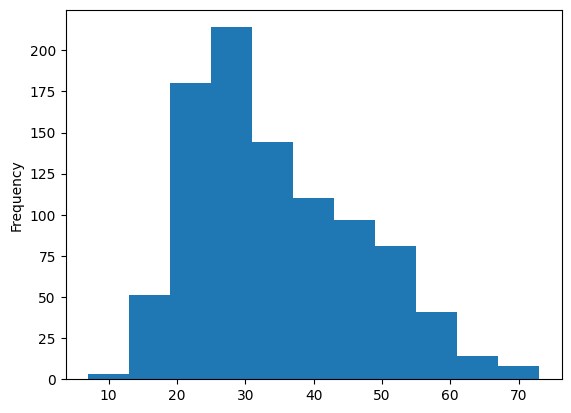

In [11]:
print(user_df.describe())
user_df['Age'].plot.hist(bins=11)

Let's see some descriptions about the categorical variables.

In [12]:
user_df.describe(include='category')

,Gender,Occupation,Postcode
count,943,943,943
unique,2,21,795
top,M,student,55414
freq,670,196,9


Below, we can see some quick plots in order to see if everything is fine.

M    670
F    273
Name: Gender, dtype: int64


<AxesSubplot: >

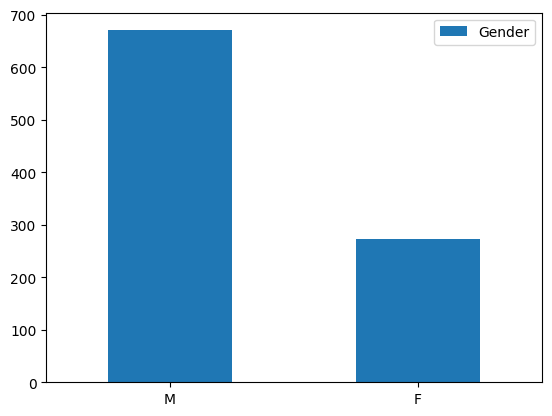

In [13]:
print(user_df['Gender'].value_counts())
user_df['Gender'].value_counts().plot.bar(legend=True, rot=0)

student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: Occupation, dtype: int64


<AxesSubplot: >

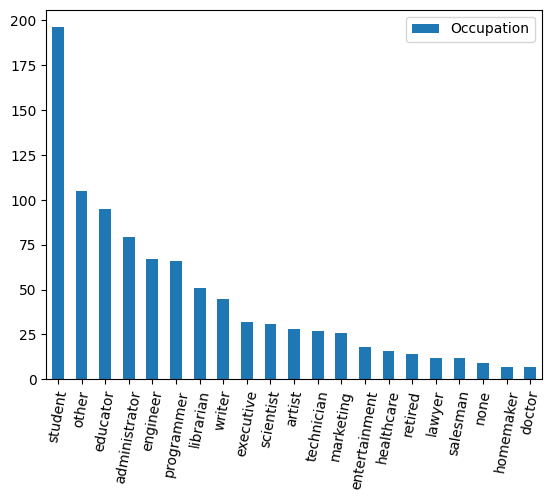

In [14]:
print(user_df['Occupation'].value_counts())
user_df['Occupation'].value_counts().plot.bar(legend=True, rot=80)

In [15]:
print(user_df['Postcode'].value_counts())
#user_df['Postcode'].value_counts().plot.bar(legend=True, rot=90)

55414    9
55105    6
20009    5
55337    5
10003    5
        ..
33205    1
33308    1
33319    1
33484    1
Y1A6B    1
Name: Postcode, Length: 795, dtype: int64


Moving on, we need the *rating_df* in order to proceed to the similarities.<br>
Now, we have *Tab* as a delimiter and we only need *UserID* and the *MovieId* they have rated.

In [16]:
rating_df = pd.read_csv('ratings.txt', delimiter='\t', names=[ 'UserId', 'MovieId', 'Rating', 'DateTime'], encoding='latin1')
#rating_df['DateTime'] = pd.to_datetime(rating_df['DateTime'], unit='s')
rating_df.drop(['Rating', 'DateTime'],axis=1, inplace=True)
rating_df

,UserId,MovieId
0,196,242
1,186,302
2,22,377
3,244,51
4,166,346
...,...,...
99995,880,476
99996,716,204
99997,276,1090
99998,13,225


Let's make some typical checks for a last time.

In [17]:
rating_df.isna().sum()

UserId     0
MovieId    0
dtype: int64

In [18]:
round(rating_df.describe(),2)

,UserId,MovieId
count,100000.00,100000.00
mean,462.48,425.53
std,266.61,330.80
min,1.00,1.00
25%,254.00,175.00
50%,447.00,322.00
75%,682.00,631.00
max,943.00,1682.00


In [19]:
rating_df['MovieId'].value_counts()

50      583
258     509
100     508
181     507
294     485
       ... 
852       1
1505      1
1653      1
1452      1
1641      1
Name: MovieId, Length: 1682, dtype: int64

Now, we need to replace __*duplicated Movie Ids*__ in order to have the right movie user has rated.

In [20]:
rating_df['MovieId'] = rating_df['MovieId'].replace(deleted_movie_ids)

Our changes were made because as we can see below, mean was changed.

In [21]:
round(rating_df.describe(),2)

,UserId,MovieId
count,100000.00,100000.00
mean,462.48,425.03
std,266.61,330.56
min,1.00,1.00
25%,254.00,175.00
50%,447.00,321.00
75%,682.00,630.00
max,943.00,1682.00


In [22]:
rating_df['MovieId'].value_counts()

50      583
258     509
100     508
181     507
294     485
       ... 
1363      1
1339      1
1570      1
1614      1
1641      1
Name: MovieId, Length: 1664, dtype: int64

## $2^{nd}$ Question : Compute exact Jaccard similarity of users<a class="anchor" id="q2"></a>
I will create a **_user_movies_** dictionary with each user and the movies he has rated.

In [23]:
# Create dictionaries to map UserId to MovieId sets
user_movies = {}
for _, row in rating_df.iterrows():
    user_id = row['UserId']
    movie_id = row['MovieId']
    if user_id not in user_movies:
        user_movies[user_id] = set()
    user_movies[user_id].add(movie_id)
#user_movies
dict(list(user_movies.items())[0:2])

{196: {8,
  13,
  25,
  66,
  67,
  70,
  94,
  108,
  110,
  111,
  116,
  153,
  173,
  202,
  238,
  242,
  251,
  257,
  269,
  285,
  286,
  287,
  306,
  340,
  381,
  382,
  393,
  411,
  428,
  580,
  655,
  663,
  692,
  762,
  845,
  1007,
  1022,
  1118,
  1241},
 186: {12,
  31,
  38,
  44,
  53,
  55,
  56,
  71,
  77,
  79,
  95,
  98,
  100,
  106,
  117,
  118,
  121,
  147,
  148,
  159,
  177,
  203,
  225,
  226,
  237,
  243,
  250,
  257,
  258,
  263,
  269,
  281,
  288,
  291,
  294,
  295,
  297,
  298,
  299,
  300,
  302,
  306,
  322,
  327,
  330,
  331,
  332,
  333,
  338,
  356,
  385,
  405,
  406,
  470,
  477,
  540,
  546,
  550,
  554,
  566,
  568,
  588,
  591,
  595,
  596,
  684,
  689,
  717,
  742,
  754,
  770,
  820,
  829,
  880,
  887,
  925,
  934,
  939,
  977,
  983,
  988,
  1016,
  1033,
  1042,
  1046,
  1083,
  1213,
  1253,
  1277,
  1336,
  1385,
  1399}}

Then, I will also create a **_movie_titles_** dictionary for mapping the *MovieId* with the *Title*.

In [24]:
# Create dictionaries to map MovieId to movie titles
movie_titles = {}
for _, row in movies_df.iterrows():
    movie_id = row['MovieId']
    movie_title = row['Title (Release Year)']
    movie_titles[movie_id] = movie_title
#movie_titles
dict(list(movie_titles.items())[0:10])

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)'}

Now, we will write a function which computes the **_jaccard similarity_**:

In [25]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / union
    return similarity

Now, we need a function which calculates the *jaccard similarity* for all users and keeps the pairs that have equal or greater than **_50% similarity_**:

In [26]:
def find_similar_pairs(user_movies):
    similar_pairs = []
    all_jaccard_pairs = []

    # Compute Jaccard similarity for all pairs of users
    for user1, user2 in combinations(user_movies.keys(), 2):
        movies1 = user_movies[user1]
        movies2 = user_movies[user2]
        similarity = jaccard_similarity(movies1, movies2)
        all_jaccard_pairs.append((user1, user2, similarity))
        if similarity >= 0.5:
            similar_pairs.append((user1, user2, similarity))

    return similar_pairs, all_jaccard_pairs

Finally, we will create a function which calculates the *common movies* **2** users have seen:

In [27]:
def get_common_movie_titles(user1_movies, user2_movies, movie_titles):
    common_movies = user1_movies.intersection(user2_movies)
    common_movie_titles = [movie_titles[movie_id] for movie_id in common_movies]
    return common_movie_titles

Below is a function which calculates the *distinct movies* **2** users have seen:

In [28]:
def get_different_movie_titles(user1_movies, user2_movies, movie_titles):
    diff_movies = user1_movies.difference(user2_movies)
    diff_movie_titles = [movie_titles[movie_id] for movie_id in diff_movies]
    return diff_movie_titles

Now, we need to execute all the aboves in order to have our result with the users:

In [29]:
# Compute similar pairs
similar_pairs, all_jaccard_pairs = find_similar_pairs(user_movies)

# Compute unsimilar pairs
# unsimilar_pairs = find_unsimilar_pairs(user_movies)

# Sort similar pairs by similarity score in descending order
similar_pairs.sort(key=lambda x: x[2], reverse=True)

# Output the pairs of users with similarity >= 0.5 and the movie titles
print("Pairs of Users with Similarity >= 0.5:")
for user1, user2, similarity in similar_pairs:
    print(f"Users {user1} and {user2} have a Jaccard similarity of {round(similarity,3)}")

# Get the movie titles for the most similar pair of users
most_similar_pair = similar_pairs[0]
user1, user2, similarity = most_similar_pair

print(f"\nCommon movies for User {user1} and User {user2} which is the most similar pair are:")
print(', '.join(get_common_movie_titles(user_movies[user1], user_movies[user2], movie_titles)))
print(f"\nUser {user1} has also see other than the common:")
print(', '.join(get_different_movie_titles(user_movies[user1], user_movies[user2], movie_titles)))
print(f"\nUser {user2} has also see other than the common:")
print(', '.join(get_different_movie_titles(user_movies[user2], user_movies[user1], movie_titles)))

Pairs of Users with Similarity >= 0.5:
Users 408 and 898 have a Jaccard similarity of 0.839
Users 328 and 788 have a Jaccard similarity of 0.673
Users 489 and 587 have a Jaccard similarity of 0.624
Users 600 and 826 have a Jaccard similarity of 0.545
Users 451 and 489 have a Jaccard similarity of 0.526
Users 674 and 879 have a Jaccard similarity of 0.522
Users 554 and 764 have a Jaccard similarity of 0.517
Users 197 and 826 have a Jaccard similarity of 0.513
Users 197 and 600 have a Jaccard similarity of 0.5
Users 800 and 879 have a Jaccard similarity of 0.5

Common movies for User 408 and User 898 which is the most similar pair are:
Contact (1997), Gattaca (1997), Starship Troopers (1997), Indian Summer (1996), Good Will Hunting (1997), Mouse Hunt (1997), English Patient, The (1996), Scream (1996), Rocket Man (1997), Air Force One (1997), L.A. Confidential (1997), Jackal, The (1997), Rainmaker, The (1997), Midnight in the Garden of Good and Evil (1997), Titanic (1997), Apt Pupil (1998

## $3^{rd}$ Question : Compute similarity using Min-hash signatures<a class="anchor" id="q3"></a>
First of all, we need to create a function for computing random hash functions.<br>
Our hash function will have the form: $h_{a,b}(x) = (a*x + b) modulo R$ with R being a large prime number.<br>
We will start by creating a function that calculates random *__a__* and *__b__* from $(0,R)$.

In [30]:
# Generate N random a and b for hash function of the form ha,b(x) = (ax + b) mod prime.
def generate_hash_functions(num_hash_functions):
    prime = 10**9 + 7
    a_values = random.sample(range(1, prime), num_hash_functions)
    b_values = random.sample(range(1, prime), num_hash_functions)
    hash_functions = list(zip(a_values, b_values))
    return hash_functions

Then, we will make a function which computes the *__minimum hash signature__*.

In [31]:
# Function to compute Min-hash signature for a set of movies(minimum of the ha,b(x) = (ax + b) mod prime)
def compute_minhash_signature(movies, hash_functions):
    signature = []
    for a, b in hash_functions:
        min_hash = min([(a * movie + b) % (10**9 + 7) for movie in movies])
        signature.append(min_hash)
    return signature

Now, we will need a function which calculates the **_Min-hash similarity_** (with the same way as jaccard similarity):

In [32]:
# Function to compute Min-hash similarity
def compute_minhash_similarity(signature1, signature2):
    num_matches = sum(h1 == h2 for h1, h2 in zip(signature1, signature2))
    num_hash_functions = len(signature1)
    similarity = num_matches / num_hash_functions
    return similarity

Below is the code for creating *50*, *100* and *200* hash functions and for each value, we will make *Min-hash similarity* *__5__* times and we will take the *average error* in the end.

In [33]:
# Define the number of hash functions
num_hash_functions = [50, 100, 200]
avg_false_positives = {}
avg_false_negatives = {}

with open('Min-Hash Pairs.txt', 'w') as f, contextlib.redirect_stdout(f):
    # Evaluate Min-hash similarity and calculate false positives and false negatives
    for num_hashes in num_hash_functions:
        false_positives_total = 0
        false_negatives_total = 0

        for i in range(5):  # Run 5 different times using different hash functions
            false_positives = 0
            false_negatives = 0

            # Compute Min-hash signatures for all users
            user_signatures = {}
            hash_functions = generate_hash_functions(num_hashes)  # Generate num_hashes hash functions
            for user, movies in user_movies.items():
                signature = compute_minhash_signature(movies, hash_functions)
                user_signatures[user] = signature
            print("-----------------------------------------------------")
            print(f"Run {i+1} with {num_hashes} Hash functions")
            for user1, user2, jac_similarity in all_jaccard_pairs:
                minhash_similarity = compute_minhash_similarity(user_signatures[user1], user_signatures[user2])
                if minhash_similarity >= 0.5:
                    print(f"Users {user1} and {user2} have a Min-Hash similarity of {minhash_similarity}")
                if minhash_similarity >= 0.5 and jac_similarity < 0.5:
                    false_positives += 1
                elif minhash_similarity < 0.5 and jac_similarity >= 0.5:
                    false_negatives += 1

            false_positives_total += false_positives
            false_negatives_total += false_negatives

        avg_false_positives[num_hashes] = false_positives_total/5
        avg_false_negatives[num_hashes] = false_negatives_total/5
        print("-----------------------------------------------------")

Below, you can see the average false positive and average false negative for each of the group of hash functions:

In [34]:
for num_hashes in num_hash_functions:
    print(f"Number of Hash Functions: {num_hashes}")
    print(f"Average False Positives: {avg_false_positives[num_hashes]}")
    print(f"Average False Negatives: {avg_false_negatives[num_hashes]}")
    print("-----------------------------------------------------")

Number of Hash Functions: 50
Average False Positives: 114.6
Average False Negatives: 3.6
-----------------------------------------------------
Number of Hash Functions: 100
Average False Positives: 31.4
Average False Negatives: 2.6
-----------------------------------------------------
Number of Hash Functions: 200
Average False Positives: 8.8
Average False Negatives: 2.4
-----------------------------------------------------


As we can see above, an increase in number of Hash Functions results to minimize the Average False Positives, leading us to perfrom similaties tests between users even better.

## $4^{th}$ Question : Locate similar users using LSH index<a class="anchor" id="q4"></a>
I will create a *user_movies* dataframe with each user and the movies he has rated.<br>

In [35]:
# Function to perform Locality Sensitive Hashing (LSH) with given parameters
def perform_lsh(user_signatures, hash_functions, b, r):
    bands = []
    for i in range(b):
        band = {}
        for user, signature in user_signatures.items():
            band_id = tuple(signature[i*r:(i+1)*r])
            if band_id not in band:
                band[band_id] = []
            band[band_id].append(user)
        bands.append(band)
    return bands

In [36]:
# Define the number of hash functions
num_hash_functions = 200
avg_true_positives_dict = {}
avg_similarity_evaluations_dict = {}

# Define LSH instances
lsh_instances = [
    {'b': 25, 'r': 8},
    {'b': 40, 'r': 5}
]

with open('LSH Pairs.txt', 'w') as f, contextlib.redirect_stdout(f):
    for lsh_instance in lsh_instances:
        b = lsh_instance['b']
        r = lsh_instance['r']

        avg_true_positives = 0
        avg_similarity_evaluations = 0

        for i in range(5):  # Run 5 different times using different hash functions
            # Compute Min-hash signatures for all users
            user_signatures = {}
            hash_functions = generate_hash_functions(num_hash_functions)  # Generate num_hash_functions hash functions
            for user, movies in user_movies.items():
                signature = compute_minhash_signature(movies, hash_functions)
                user_signatures[user] = signature

            # Perform Locality Sensitive Hashing (LSH)
            bands = perform_lsh(user_signatures, hash_functions, b, r)

            # Find similar user pairs with Jaccard similarity at least 0.5
            true_positives = set()
            similarity_evaluations = 0

            for band in bands:
                for bucket in band.values():
                    if len(bucket) > 1:
                        for j in range(len(bucket)):
                            for k in range(j+1, len(bucket)):
                                user1 = bucket[j]
                                user2 = bucket[k]
                                jaccard_sim = jaccard_similarity(user_movies[user1], user_movies[user2])
                                similarity_evaluations += 1
                                if jaccard_sim >= 0.5:
                                    true_positives.add((user1, user2))

            avg_true_positives += len(true_positives)
            avg_similarity_evaluations += similarity_evaluations
            print("-----------------------------------------------------")
            print(f"Run {i+1} with LSH Instance: b = {b}, r = {r}")
            print(f"True Positives: {true_positives}")
            print(f"Similarity Evaluations: {similarity_evaluations}")

        print("-----------------------------------------------------")
        avg_true_positives_dict[(b, r)] = avg_true_positives / 5
        avg_similarity_evaluations_dict[(b, r)] = avg_similarity_evaluations / 5

Below, you can see the average True Positives and the average similarity evaluations for each instance of LSH.

In [37]:
for lsh_instance in lsh_instances:
    b = lsh_instance['b']
    r = lsh_instance['r']
    print("-----------------------------------------------------")
    print(f"LSH Instance: b = {b}, r = {r}")
    print(f"Average True Positives: {avg_true_positives_dict[(b, r)]}")
    print(f"Average Similarity Evaluations: {avg_similarity_evaluations_dict[(b, r)]}")
    print("-----------------------------------------------------")

-----------------------------------------------------
LSH Instance: b = 25, r = 8
Average True Positives: 2.8
Average Similarity Evaluations: 48.2
-----------------------------------------------------
-----------------------------------------------------
LSH Instance: b = 40, r = 5
Average True Positives: 8.2
Average Similarity Evaluations: 2646.2
-----------------------------------------------------


The reported results will provide insights into the effectiveness of LSH compared to directly comparing users based on their true representations.<br>LSH can significantly reduce the number of similarity evaluations by first identifying candidate pairs using the LSH index.<br>This trade-off allows for faster identification of potential similar users while sacrificing some accuracy in terms of false positives and false negatives.<br>By adjusting the values of *b* and *r*, you can control the balance between accuracy and performance in LSH.

By using LSH, we gain efficiency in terms of the number of similarity evaluations performed. LSH allows us to identify potential similar pairs by hashing them into the same buckets, reducing the number of comparisons needed. We only evaluate the true similarity for the pairs that are in the same bucket, resulting in a significant reduction in the number of similarity evaluations.

However, using LSH may introduce false negatives, as some similar pairs might not be hashed into the same bucket. LSH is a trade-off between efficiency and accuracy. By using LSH, we gain computational efficiency by reducing the number of similarity evaluations but may lose some accuracy by potentially missing some true similar pairs.

The results demonstrate the trade-off between the number of true positives and the number of similarity evaluations when using LSH. The LSH instance with b = 40 and r = 5 achieved a higher average number of true positives but required a significantly larger number of similarity evaluations compared to the LSH instance with b = 25 and r = 8.

By using LSH, we gain efficiency in terms of the reduced number of similarity evaluations. However, increasing the number of bands (b) and reducing the number of hash functions per band (r) can lead to a higher chance of false positives and a larger number of similarity evaluations. The choice of b and r depends on the specific requirements of the application, balancing the trade-off between efficiency and accuracy.